In [1]:
import numpy as np
import cv2
import json
from paz.core import ops
from mrcnn import visualize, utils
import tensorflow as tf
import matplotlib.pyplot as plt
from pose_estimation.solver import PnPSolver
from pose_estimation.pose_evaluation import PoseError
from pose_estimation.pose import compute_poses

In [76]:
results_path = '/home/incendio/Desktop/inference_results/for_10k_data/mse/90_epochs/results.json'
ground_truth_path = '/home/incendio/Desktop/inference_results/for_10k_data/mse/90_epochs/ground_truth.json'
with open(results_path, 'r') as f:
    results = json.load(f)
    
with open(ground_truth_path, 'r') as f:
    ground_truth = json.load(f)

[ 9  8  6  1 19  2  4]
010_potted_meat_can
009_gelatin_box
007_tuna_fish_can
002_master_chef_can
051_large_clamp
003_cracker_box
005_tomato_soup_can


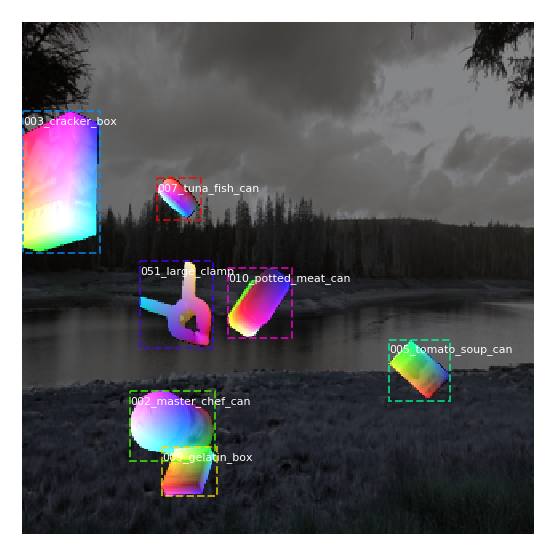

In [86]:
img_path = '/home/incendio/Desktop/inference_results/for_10k_data/mse/90_epochs/image.png'

def prepare_results(path, data, is_gt=True):
    img = cv2.imread(path)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    box = np.array(data['rois'])
    class_id = np.array(data['class_ids'])
    if is_gt:
        r_mask = np.array(data['gt_r_masks'])
        g_mask = np.array(data['gt_g_masks'])
        b_mask = np.array(data['gt_b_masks'])
    else:
        r_masks = np.array(r['r_masks'])
        g_masks = np.array(r['g_masks'])
        b_masks = np.array(r['b_masks'])
    r_mask = (r_mask * 255).astype(np.uint8)
    g_mask = (g_mask * 255).astype(np.uint8)
    b_mask = (b_mask * 255).astype(np.uint8)
    masks = []
    for i in range(r_mask.shape[-1]):
        mask = np.stack([r_mask[:, :, i], g_mask[:, :, i], b_mask[:, :, i]], axis=2)
        masks.append(mask)
    masks = np.stack(masks, axis=2)
    masks = np.reshape(masks, (320, 320, 3*7))
    return image, box, class_id, masks
    
class_names = ['background', '002_master_chef_can', '003_cracker_box',
               '004_sugar_box', '005_tomato_soup_can', '006_mustard_bottle',
               '007_tuna_fish_can', '008_pudding_box', '009_gelatin_box',
               '010_potted_meat_can', '011_banana', '019_pitcher_base',
               '021_bleach_cleanser', '024_bowl',
               '025_mug', '035_power_drill',
               '036_wood_block', '037_scissors',
               '040_large_marker', '051_large_clamp',
               '052_extra_large_clamp', '061_foam_brick']
image, gt_box, gt_class_id, gt_masks = prepare_results(img_path, ground_truth)
print(gt_class_id)
for i in gt_class_id:
    print(class_names[i])
m = np.zeros(gt_masks.shape)
m[:, :, 12:15] = gt_masks[:, :, 12:15]
gt = visualize.display_rgb_instances(image, gt_box, gt_masks, gt_class_id, class_names, show_bbox=True, figsize=(10, 10))

[ 6 12  2 12 20  8  1 19  7]
007_tuna_fish_can
021_bleach_cleanser
003_cracker_box
021_bleach_cleanser
052_extra_large_clamp
009_gelatin_box
002_master_chef_can
051_large_clamp
008_pudding_box


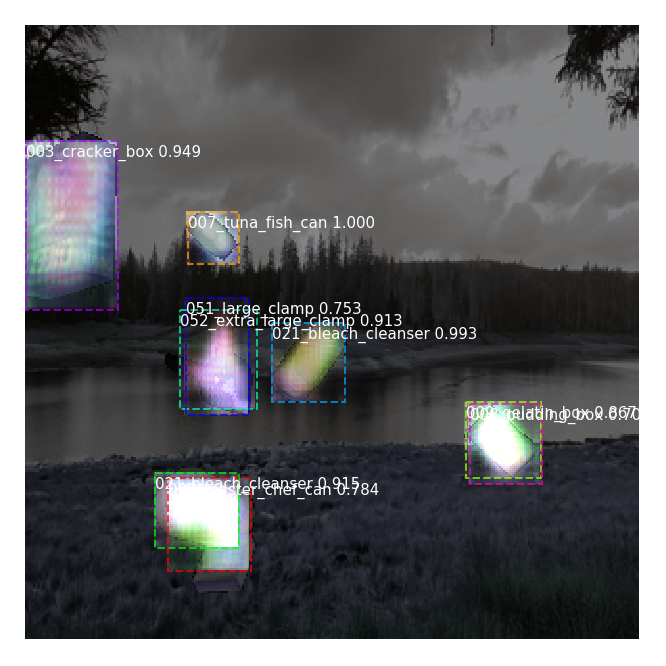

In [80]:
r = results
rois = np.array(r['rois'])
class_ids = np.array(r['class_ids'])
N = len(class_ids)

r_masks = np.array(r['r_masks'])
g_masks = np.array(r['g_masks'])
b_masks = np.array(r['b_masks'])

r_masks = (r_masks * 255).astype(np.uint8)
g_masks = (g_masks * 255).astype(np.uint8)
b_masks = (b_masks * 255).astype(np.uint8)
masks = []
for i in range(r_masks.shape[-1]):
    masks.append(np.stack([r_masks[:, :, i], g_masks[:, :, i], b_masks[:, :, i]], axis=2))
masks = np.stack(masks)
print(class_ids)
for i in class_ids:
    print(class_names[i])
#     [ 7 18 16 15 20  3 21]
_ = visualize.display_test_instances(image, rois, masks, class_ids, class_names, results['scores'], show_bbox=True, figsize=(12, 12))

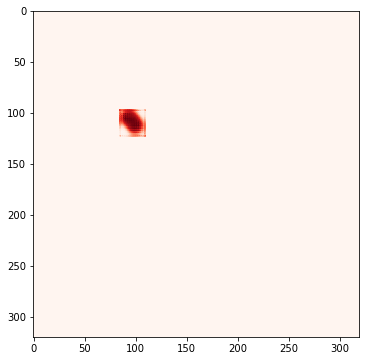

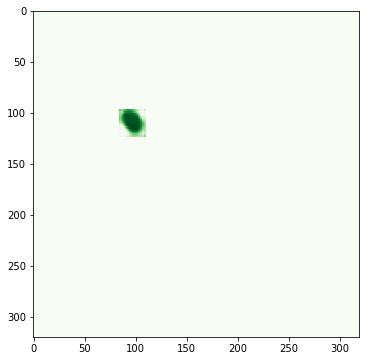

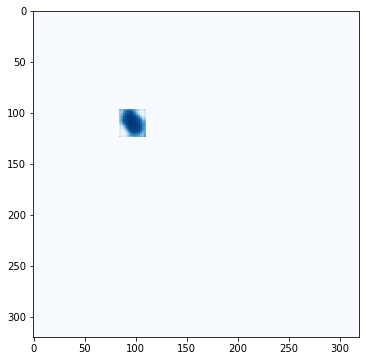

In [93]:
def plot_channels(mask, channel):
    fig = plt.figure(figsize=(6, 6))
    if channel == 'r':
        plt.imshow(mask, cmap='Reds')
    if channel == 'g':
        plt.imshow(mask, cmap='Greens')
    if channel == 'b':
        plt.imshow(mask, cmap='Blues')
    plt.show()
    
pr_id = 0
m = masks[pr_id]
plot_channels(m[..., 0], 'r')
plot_channels(m[..., 1], 'g')
plot_channels(m[..., 2], 'b')

In [94]:
from skimage.metrics import mean_squared_error
print(mean_squared_error(gt_masks[:, :, 2*3], masks[pr_id][:, :, 0]))
print(mean_squared_error(gt_masks[:, :, 2*3+1], masks[pr_id][:, :, 1]))
print(mean_squared_error(gt_masks[:, :, 2*3+2], masks[pr_id][:, :, 2]))

23.6068359375
39.555390625
35.19291015625


In [75]:
def evaluation(gt_mask, pred_mask, true_id, name):
    pnp = PnPSolver(gt_mask, true_id, name)
    gt_points3d, image2d = pnp.get_points()
    camera = pnp.compute_camera_matrix()
    _, true_R, true_T, inliers = ops.solve_PNP(gt_points3d, image2d, camera, ops.UPNP)
#     model_point = pnp.get_object_points(image2d)
#     model_point = np.diag(model_point)[..., np.newaxis].T
#     true_R, true_T, _ = pnp.solve_PnP()
    est_pnp = PnPSolver(pred_mask, true_id, name)
    points3d, image2d = est_pnp.get_points()
    _, est_R, est_T, est_inliers = ops.solve_PNP(points3d, image2d, camera, ops.UPNP)
#     est_R, est_T, _ = est_pnp.solve_PnP()
    error = PoseError(gt_points3d, est_R, est_T, true_R, true_T)
    add = error.add()
    adi = error.adi()
    rot_error = error.rotational_error()
    trans_error = error.translational_error()
    return add, adi, rot_error, trans_error

all_scores = {}
names = ['background', '01_master_chef_can', '02_cracker_box',
           '03_sugar_box', '04_tomato_soup_can', '05_mustard_bottle',
           '06_tuna_fish_can', '07_pudding_box', '08_gelatin_box',
           '09_potted_meat_can', '10_banana', '11_pitcher_base',
           '12_bleach_cleanser', '13_bowl',
           '14_mug', '15_power_drill',
           '16_wood_block', '17_scissors',
           '18_large_marker', '19_large_clamp',
           '20_extra_large_clamp', '21_foam_brick']
for id_, class_id in enumerate(gt_class_id):
    if class_id in class_ids:
        m_id = np.where(class_id == class_ids)
#         class_id = 2
        pred_mask = masks[m_id]
        gt_ = np.where(class_id == gt_class_id)[0][0]
        gt_mask = gt_masks[:, :, gt_*3:gt_*3+3]
        name = names[class_id]
        # print(name)
        add, adi, re, te = evaluation(gt_mask, pred_mask[0], class_id, name)
        print(name)
        all_scores[name] = [add, adi, re, te]

error: OpenCV(4.2.0) /io/opencv/modules/calib3d/src/solvepnp.cpp:216: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'


In [44]:
all_scores

{'20_extra_large_clamp': [0.6204132013836992,
  0.5332623221321993,
  120.9013277476428,
  0.6220231702097303]}

In [36]:
boxed = gt.copy()
# for m_id, class_id in zip(good_ids, good_class):
m_id = 4
class_id = 20
name = class_names[class_id]
i = m_id * 3
# m = masks[0]
mask = gt_masks[:, :, i:i+3].astype(np.uint8)
# name = class_names[class_id]
pnp = PnPSolver(mask, int(class_id), name, dimension=[.06, .06])
gt_poses = pnp.solve_PnP()
args, pr_points = pnp.visualize_3D_boxes(boxed, gt_poses)

In [37]:
# boxed = image.copy()
# # for m_id, class_id in zip(good_ids, good_class):
# m_id = 4
class_id = 20
name = class_names[class_id]
# i = m_id * 3
m = masks[0]
# mask = gt_masks[:, :, i:i+3].astype(np.uint8)
# name = class_names[class_id]
pnp = PnPSolver(m, int(class_id), name, color=(255, 0, 0), dimension=[.02, .02])
gt_poses = pnp.solve_PnP()
args, pr_points = pnp.visualize_3D_boxes(boxed, gt_poses)

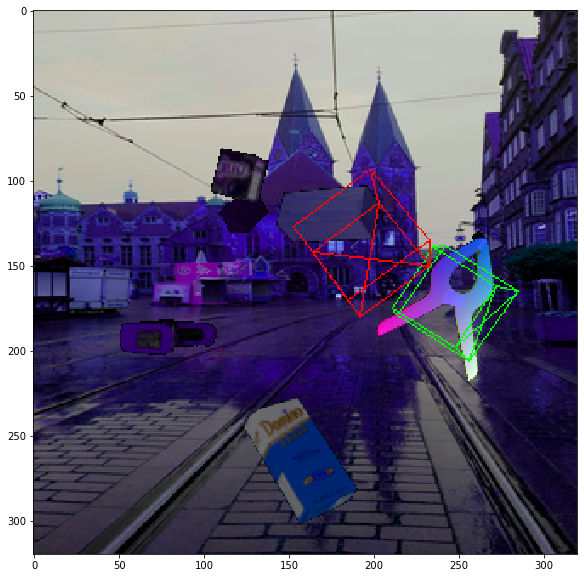

In [38]:
fig = plt.figure(figsize=(10, 10))
# y = cv2.add(boxed, pnp.draw_axis(mask, pr_points))
plt.imshow(args['image'])
plt.show()

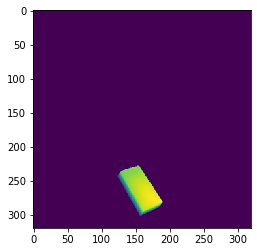

In [67]:
plt.imshow(gt_masks[:, :, 15])

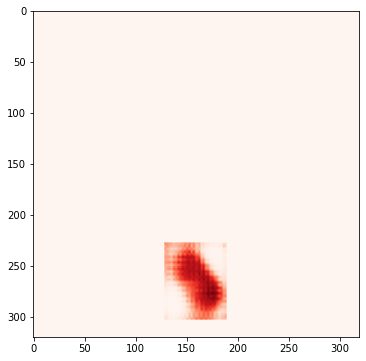

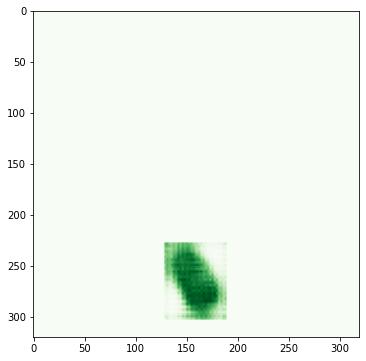

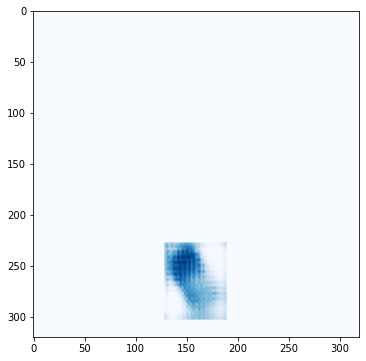

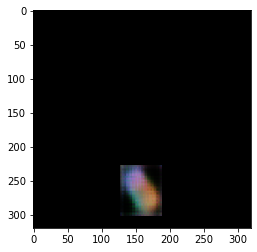

282.221611328125
194.23669921875
202.663203125


In [73]:
from skimage.metrics import structural_similarity as ssim
print(ssim(gt_masks[:, :, 15], masks[pr_id][:, :, 0]))

0.9607694481307518


In [40]:
gt_r_mask = np.array(ground_truth['gt_r_masks'])
gt_g_mask = np.array(ground_truth['gt_g_masks'])
gt_b_mask = np.array(ground_truth['gt_b_masks'])

r_masks = np.array(results['r_masks'])
g_masks = np.array(results['g_masks'])
b_masks = np.array(results['b_masks'])
scores = np.array(results['scores'])

AP, precision, recall, overlaps = utils.compute_ap(gt_box, gt_class_id, gt_r_mask, gt_g_mask, gt_b_mask,
                                                   rois, class_ids, scores, r_masks, g_masks, b_masks)

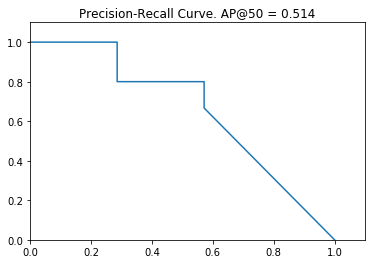

In [41]:
visualize.plot_precision_recall(AP, precision, recall)

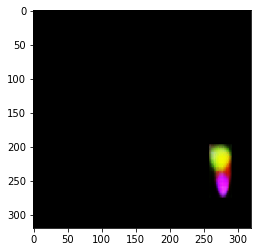

In [72]:
plt.imshow(masks[1])

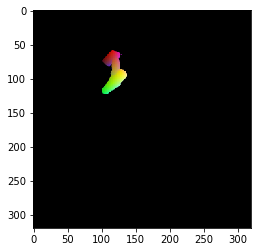

In [64]:
plt.imshow(gt_masks[:, :, 6:9])

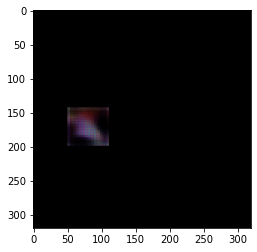

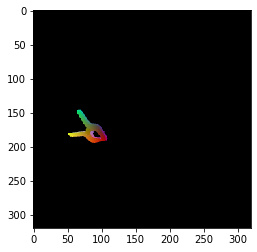

112.01814778645833
0.9611940475786623


In [52]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

m_id = 2
m = masks[m_id]

gt_id = 0 * 3
plt.imshow(m)
plt.show()
gt = gt_masks[:, :, gt_id:gt_id+3]
plt.imshow(gt)
plt.show()
print(mean_squared_error(gt, m))
print(ssim(gt[:, :, 0], m[:, :, 0]))

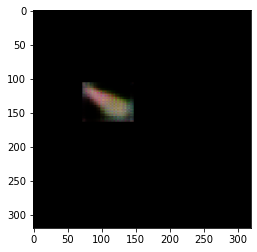

In [33]:
plt.imshow(masks[2])

import skimage
# convert to hsv
lab = cv2.cvtColor(masks[2],cv2.COLOR_BGR2LAB)
L = lab[:,:,0]
A = lab[:,:,1]
B = lab[:,:,2]

# negate A
A = (255 - A)
# multiply negated A by B
nAB = 255 * (A/255) * (B/255)
nAB = np.clip((nAB), 0, 255)
nAB = np.uint8(nAB)
# threshold using inRange
range1 = 100
range2 = 160
mask = cv2.inRange(nAB,range1,range2)
mask = 255 - mask
# apply morphology opening to mask
kernel = np.ones((3,3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_ERODE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# antialias mask
mask = cv2.GaussianBlur(mask, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)
mask = skimage.exposure.rescale_intensity(mask, in_range=(127.5,255), out_range=(0,255))

# put white where ever the mask is zero
result = masks[2].copy()
result[mask==0] = (255,255,255)
cv2.imwrite('x.png', result)
plt.imshow(result)

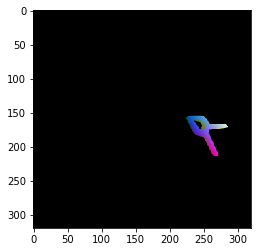

In [18]:
plt.imshow(gt_masks[:, :, 18:21])